In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
import keras.layers as ll
from keras.models import Sequential
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

from mpl_toolkits.mplot3d import Axes3D
%pylab inline

/home/hellmetler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


### Preproc

In [2]:
data_path = '../data/raw/'
interim_path = '../data/interim/'
result_path = '../submits/'
figures_path = '../reports/figures/'

In [3]:
train = pd.read_csv(data_path+'train.csv', index_col=0, 
                    dtype={'meter_id':str,'Timestamp':str, 'Values':np.float32})
test = pd.read_csv(data_path+'submission_format.csv',dtype={'obs_id':np.int32,'meter_id':str,
                                                            'Timestamp':str, 'is_abnormal':bool})
metadata = pd.read_csv(data_path+'metadata.csv',dtype={'site_id':str,'meter_id':str,'meter_description':str,
                                                            'units':str, 'surface':np.float32,'activity':str})
holidays =  pd.read_csv(data_path+'holidays.csv', index_col=0, 
                    dtype={'Date':str,'Holiday':str, 'site_id':str})
weather =  pd.read_csv(data_path+'weather.csv', index_col=0, 
                    dtype={'Timestamp':str,'Temperature':np.float32,'Distance':np.float32 ,'site_id':str})

train.Timestamp = pd.to_datetime(train.Timestamp)
test.Timestamp = pd.to_datetime(test.Timestamp)
holidays.Date = pd.to_datetime(holidays.Date)
weather.Timestamp = pd.to_datetime(weather.Timestamp)

/home/hellmetler/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
train = train.join(metadata.set_index('meter_id',drop = True), on = 'meter_id')

In [5]:
meter = '38_9686'
site = train[train['meter_id']==meter].site_id.unique()[0]

holidays = holidays[holidays['site_id']==site]

train = train[train['site_id']==site]
weather = weather[weather['site_id']==site]
weather = weather.groupby('Timestamp',as_index= False).mean()

In [6]:
tmp = train[['meter_id','meter_description','units','surface']]

In [7]:
%%time
train_left = train[train['meter_id']==meter]
for met_id in train['meter_id'].unique():
    if met_id != meter:
        tmp = train.loc[train['meter_id']==met_id,['Timestamp','Values']].set_index('Timestamp',drop = True)
        train_left = train_left.join(tmp, on = 'Timestamp',rsuffix = '_'+met_id )
train = train_left
del train_left

CPU times: user 6min 5s, sys: 287 ms, total: 6min 5s
Wall time: 6min 5s


In [8]:
def basic_feature_engineering(df):
    
    night_hours = {20:0,21:1,22:2,23:3,0:4,1:5,2:6,3:7,4:8,5:9,6:10}
    day_hours = dict([(h,i) for i,h in enumerate(range(7,20))])
    
    df['year'] = pd.DatetimeIndex(df['Timestamp']).year
    df['month'] = pd.DatetimeIndex(df['Timestamp']).month
    
    df['month_sin'] = np.sin(df['month']*2*pi/12)
    df['month_cos'] = np.cos(df['month']*2*pi/12)
    
    
    df['day'] = pd.DatetimeIndex(df['Timestamp']).day
        
    df['day_sin'] = np.sin(df['day']*2*pi/30)
    df['day_cos'] = np.cos(df['day']*2*pi/30)
    
    df['day_of_week'] = pd.DatetimeIndex(df['Timestamp']).weekday_name
    df['woking_day'] = (df['day_of_week']!= 'Saturday' )&(df['day_of_week']!= 'Sunday' )
    df['weekofyear'] = pd.DatetimeIndex(df['Timestamp']).weekofyear
    df['weekofyear_sin'] = np.sin(df['weekofyear']*2*pi/52)
    df['weekofyear_cos'] = np.cos(df['weekofyear']*2*pi/52)
    
    df['dayofyear'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
    df['dayofyear_sin'] = np.sin(df['dayofyear']*2*pi/365)
    df['dayofyear_cos'] = np.cos(df['dayofyear']*2*pi/365)
    
    
    df['hour'] = pd.DatetimeIndex(df['Timestamp']).hour
    
    df['hour_sin'] = np.sin(df['hour']*2*pi/24)
    df['hour_cos'] = np.cos(df['hour']*2*pi/24)
    
    df.loc[(((df['hour']>=20 )&(df['hour']<= 23 ))|((df['hour']>=0 )&(df['hour']< 7 ))),'night']= True
    df['night'].fillna(False,inplace = True)
    
    df.loc[df['night']==True,'reset_hour']= df.loc[df['night']==True,'hour'].apply(lambda x: night_hours[x] )
    df.loc[df['night']==False,'reset_hour']= df.loc[df['night']==False,'hour'].apply(lambda x: day_hours[x] )
    
    df.loc[(((df['hour']>=22 )&(df['hour']<= 23 ))|((df['hour']>=0 )&(df['hour']< 7 ))),'time_of_day']= 0
    df.loc[(((df['hour']>=7 )&(df['hour']< 10 ))|((df['hour']>=18 )&(df['hour']< 22 ))),'time_of_day']= 1
    df.loc[(((df['hour']>=10 )&(df['hour']< 18 ))),'time_of_day']= 2
    
    df['minute'] = pd.DatetimeIndex(df['Timestamp']).minute
    return df

In [9]:
train = basic_feature_engineering(train)

In [10]:
train.dropna(subset = ['Values'], inplace = True)

In [11]:
train['Temperature'] = train['Values_38_9801']
train.drop('Values_38_9801',axis = 1, inplace = True)

In [12]:
train['Temperature_sq']=train['Temperature']**2

In [13]:
train = train.join(train[['year','month','day','Temperature']].groupby(['year','month','day']).mean(),
           on = ['year','month','day'],rsuffix = '_mean_date')

In [14]:
train['night'] = train['night'].astype(int)
train = train.join(train[['year','month','day','night','Temperature']].groupby(['year','month','day','night']).mean(),
           on = ['year','month','day','night'],rsuffix = '_mean_time_of_day')

In [15]:
holidays['year'] = pd.DatetimeIndex(holidays['Date']).year
holidays['month'] = pd.DatetimeIndex(holidays['Date']).month
holidays['day'] = pd.DatetimeIndex(holidays['Date']).day
holidays['is_holiday'] = True
holidays.drop_duplicates(subset = ['Date'], inplace = True)

In [16]:
train = train.join(holidays[['year','month','day','is_holiday']].set_index(['year','month','day']),
                   on = ['year','month','day'])

In [17]:
all_values = train[['meter_id','Timestamp','Values']]

In [18]:
train = train[train['is_holiday']!=True]

In [19]:
train.is_holiday.fillna(False, inplace = True)
train['is_holiday'] = train['is_holiday'].astype(int)

In [20]:
train['is_abnormal'] = False

In [21]:
train['high_temp'] =train ['Temperature_mean_date']>17
train['low_temp'] =train ['Temperature_mean_date']<10

#train.loc[(train.Timestamp>'2015-08-09')&(train.Timestamp<'2015-08-15'),'is_holiday']= True
train.loc[((train['woking_day']==True)&(train['high_temp']==True)&(train['low_temp']==False)),'model_num'] = 1
train.loc[((train['woking_day']==True)&(train['high_temp']==False)&(train['low_temp']==False)),'model_num'] = 2
train.loc[((train['woking_day']==False)&(train['high_temp']==False)&(train['low_temp']==False)),'model_num'] = 3
train.loc[((train['woking_day']==False)&(train['high_temp']==True)&(train['low_temp']==False)),'model_num'] = 4

train.loc[((train['woking_day']==True)&(train['high_temp']==False)&(train['low_temp']==True)),'model_num'] = 5
train.loc[((train['woking_day']==False)&(train['high_temp']==False)&(train['low_temp']==True)),'model_num'] = 6
train ['model_num'].fillna(0,inplace = True)


In [22]:
train['Values_mod'] = train['Values']
train['diff_tmp'] = train['Values'].diff().shift(-1)<-1000000
for ind in train[train['diff_tmp']==True].index:
    train.loc[train.Timestamp > train.loc[ind,'Timestamp'],'Values_mod'] = train.loc[train.Timestamp > 
                                                                train.loc[ind,'Timestamp'],'Values_mod']+10000000

In [23]:
train.drop('diff_tmp',axis = 1,inplace = True)

In [24]:
train['Values_mod'] = train.Values_mod.diff()

In [25]:
train.Values_mod = train.Values_mod/((pd.TimedeltaIndex(train.Timestamp.diff())).total_seconds())*60*15

In [26]:
train['month'] = pd.DatetimeIndex(train.Timestamp).month
train['day'] = pd.DatetimeIndex(train.Timestamp).day

In [27]:
train.drop(train[(train.month==12)&((train.day>=23))].index, inplace = True)
train.drop(train[(train.month==1)&((train.day<=10))].index, inplace = True)

In [28]:
train.Temperature.fillna(method = 'ffill', inplace = True)
train.Temperature.fillna(method = 'bfill', inplace = True)

In [29]:
#use only piece of data
train = train[train['Timestamp']>'2015-01-01']

### modelling

In [30]:
scaler = StandardScaler()

In [31]:
cols = ['dayofyear','weekofyear','woking_day', 'weekofyear_sin', 'weekofyear_cos','dayofyear_sin','dayofyear_cos', 
        'hour_sin',  'hour_cos', 'night','Temperature', 'Temperature_sq','Temperature_mean_date',
        'Temperature_mean_time_of_day','Values_mod','Values_38_9687']



x_cols = ['Temperature_mean_time_of_day','Temperature_mean_date','dayofyear_sin','dayofyear_cos','Temperature',
        'hour_sin', 'hour_cos']


scale_cols = ['Temperature_mean_time_of_day','Temperature_mean_date','Temperature']

target = 'Values_mod'


#### working day high temp

In [32]:
train_1 = train.loc[(train['model_num']==1)].copy()

In [33]:
##knn
model = KNeighborsRegressor(n_neighbors=1000,p=1, n_jobs=-1)
scaler = StandardScaler()

x_train = train_1.dropna(subset = x_cols)[x_cols]


x_train.loc[:,scale_cols] = scaler.fit_transform(x_train[scale_cols].values)

y_train = train_1.dropna(subset = x_cols)[target]

model.fit(x_train,y_train)
y_pred = model.predict(x_train)
(mean_absolute_error(y_train,y_pred))

22.059135771418415

In [34]:
train_1.loc[x_train.index,'Values_pred_2'] = y_pred
train_1['error_2'] = (train_1[target]-train_1['Values_pred_2'])
train_1['metric_2'] = np.abs(train_1['error_2']-train_1['error_2'].mean())/(train_1['error_2'].std())

In [35]:
threshold = 4.0
train_1['is_abnormal_2']=train_1['metric_2']>threshold
train_1['is_abnormal_2'].fillna(False,inplace = True)

In [36]:
train_1['is_abnormal_2'].sum()

117

In [37]:
## nn 

In [38]:
cols_nn = [target,'Temperature','hour','year','month','day_of_week']
x_cols_nn = ['Temperature','hour','year','month','day_of_week']

In [39]:

x_df = train_1[cols_nn].dropna(subset = [target])
x_df['day_of_week'] = pd.factorize(x_df['day_of_week'])[0]
x_df.loc[:,x_cols_nn] = x_df[x_cols_nn].fillna(x_df[x_cols_nn].median())

In [40]:
scaler = StandardScaler()
X = scaler.fit_transform(x_df[x_cols_nn])

In [41]:
model = Sequential()
model.add(ll.InputLayer(input_shape=[X.shape[1],]))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1))
model.compile('adam',loss='mae')

In [42]:
model.fit(X,x_df[target],epochs=5,batch_size=64)

Epoch 1/5
27840/27840 [==============================] - 27s 963us/step - loss: 42.5157
Epoch 2/5
27840/27840 [==============================] - 27s 957us/step - loss: 27.3633
Epoch 3/5
27840/27840 [==============================] - 26s 925us/step - loss: 24.0560
Epoch 4/5
27840/27840 [==============================] - 26s 916us/step - loss: 23.9357
Epoch 5/5
27840/27840 [==============================] - 26s 948us/step - loss: 23.2954


In [43]:
y_pred = model.predict(X)

In [44]:
train_1.loc[x_df.index,'Values_pred_1'] = y_pred
train_1['error_1'] = (train_1[target]-train_1['Values_pred_1'])
train_1['metric_1'] = np.abs(train_1['error_1']-train_1['error_1'].mean())/(train_1['error_1'].std())

In [45]:
threshold =3.8
train_1['is_abnormal_1']=(train_1['metric_1']>threshold)
train_1['is_abnormal_1'].fillna(False,inplace = True)

In [46]:
train_1['is_abnormal_1'].sum()

189

In [47]:
train.loc[train_1.index,'is_abnormal_1'] = train_1['is_abnormal_1']
train.loc[train_1.index,'Values_pred_1'] = train_1['Values_pred_1']
train.loc[train_1.index,'metric_1'] = train_1['metric_1']

train.loc[train_1.index,'is_abnormal_2'] = train_1['is_abnormal_2']
train.loc[train_1.index,'Values_pred_2'] = train_1['Values_pred_2']
train.loc[train_1.index,'metric_2'] = train_1['metric_2']

#### working day_low temp

In [48]:
train_1 = train.loc[(train['model_num']==2)].dropna(subset = [target]).copy()

In [49]:
##knn
model = KNeighborsRegressor(n_neighbors=1000,p=1, n_jobs=-1)
scaler = StandardScaler()

x_train = train_1.dropna(subset = x_cols)[x_cols]


x_train.loc[:,scale_cols] = scaler.fit_transform(x_train[scale_cols].values)

y_train = train_1.dropna(subset = x_cols)[target]

model.fit(x_train,y_train)
y_pred = model.predict(x_train)
(mean_absolute_error(y_train,y_pred))

18.404659768077121

In [50]:
train_1.loc[x_train.index,'Values_pred_2'] = y_pred
train_1['error_2'] = (train_1[target]-train_1['Values_pred_2'])
train_1['metric_2'] = np.abs(train_1['error_2']-train_1['error_2'].mean())/(train_1['error_2'].std())

threshold = 3.5
train_1['is_abnormal_2']=train_1['metric_2']>threshold
train_1['is_abnormal_2'].fillna(False,inplace = True)

In [51]:
x_df = train_1[cols_nn].dropna(subset = [target])
x_df['day_of_week'] = pd.factorize(x_df['day_of_week'])[0]
x_df.loc[:,x_cols_nn] = x_df[x_cols_nn].fillna(x_df[x_cols_nn].median())

In [52]:
scaler = StandardScaler()
X = scaler.fit_transform(x_df[x_cols_nn])

In [53]:
model = Sequential()
model.add(ll.InputLayer(input_shape=[X.shape[1],]))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1))
model.compile('adam',loss='mae')

In [54]:
model.fit(X,x_df[target],epochs=5,batch_size=64)

Epoch 1/5
21117/21117 [==============================] - 20s 954us/step - loss: 38.7361
Epoch 2/5
21117/21117 [==============================] - 20s 938us/step - loss: 25.0596
Epoch 3/5
21117/21117 [==============================] - 20s 936us/step - loss: 22.0083
Epoch 4/5
21117/21117 [==============================] - 21s 993us/step - loss: 20.8284
Epoch 5/5
21117/21117 [==============================] - 20s 944us/step - loss: 20.1190


In [55]:
y_pred = model.predict(X)

In [56]:
train_1.loc[x_df.index,'Values_pred_1'] = y_pred
train_1['error_1'] = (train_1[target]-train_1['Values_pred_1'])
train_1['metric_1'] = np.abs(train_1['error_1']-train_1['error_1'].mean())/train_1['error_1'].std()

threshold = 4.
train_1['is_abnormal_1']=train_1['metric_1']>threshold
train_1['is_abnormal_1'].fillna(False,inplace = True)

In [57]:
train_1.is_abnormal_1.sum()

125

In [58]:
train_1.is_abnormal_2.sum()

162

In [59]:
(train_1.is_abnormal_1&train_1.is_abnormal_2).sum()

66

In [60]:
train.loc[train_1.index,'is_abnormal_1'] = train_1['is_abnormal_1']
train.loc[train_1.index,'Values_pred_1'] = train_1['Values_pred_1']
train.loc[train_1.index,'metric_1'] = train_1['metric_1']

train.loc[train_1.index,'is_abnormal_2'] = train_1['is_abnormal_2']
train.loc[train_1.index,'Values_pred_2'] = train_1['Values_pred_2']
train.loc[train_1.index,'metric_2'] = train_1['metric_2']

#### weekend_low temp

In [61]:
train_1 = train.loc[(train['model_num']==3)].dropna(subset = [target]).copy()

In [62]:
##knn
model = KNeighborsRegressor(n_neighbors=1000,p=1, n_jobs=-1)
scaler = StandardScaler()

x_train = train_1.dropna(subset = x_cols)[x_cols]
x_train.loc[:,scale_cols] = scaler.fit_transform(x_train[scale_cols].values)
y_train = train_1.dropna(subset = x_cols)[target]

model.fit(x_train,y_train)
y_pred = model.predict(x_train)
(mean_absolute_error(y_train,y_pred))

8.8075304367555276

In [63]:
train_1.loc[x_train.index,'Values_pred_2'] = y_pred
train_1['error_2'] = (train_1[target]-train_1['Values_pred_2'])
train_1['metric_2'] = np.abs(train_1['error_2']-train_1['error_2'].mean())/(train_1['error_2'].std())

threshold = 3.
train_1['is_abnormal_2']=train_1['metric_2']>threshold
train_1['is_abnormal_2'].fillna(False,inplace = True)

In [64]:
x_df = train_1[cols_nn].dropna(subset = [target])
x_df['day_of_week'] = pd.factorize(x_df['day_of_week'])[0]
x_df.loc[:,x_cols_nn] = x_df[x_cols_nn].fillna(x_df[x_cols_nn].median())

In [65]:
scaler = StandardScaler()

X =scaler.fit_transform(x_df[x_cols_nn])

In [66]:
model = Sequential()
model.add(ll.InputLayer(input_shape=[X.shape[1],]))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1))
model.compile('adam',loss='mae')

In [67]:
model.fit(X,x_df[target],epochs=5,batch_size=64)

Epoch 1/5
9007/9007 [==============================] - 9s 955us/step - loss: 17.5995
Epoch 2/5
9007/9007 [==============================] - 8s 918us/step - loss: 14.3372
Epoch 3/5
9007/9007 [==============================] - 9s 1ms/step - loss: 13.6514
Epoch 4/5
9007/9007 [==============================] - 8s 937us/step - loss: 13.2625
Epoch 5/5
9007/9007 [==============================] - 8s 919us/step - loss: 13.0795


In [68]:
y_pred = model.predict(X)

In [69]:
train_1.loc[x_df.index,'Values_pred_1'] = y_pred
train_1['error_1'] = (train_1[target]-train_1['Values_pred_1'])
train_1['metric_1'] = np.abs(train_1['error_1']-train_1['error_1'].mean())/train_1['error_1'].std()


threshold =3.
train_1['is_abnormal_1']=train_1['metric_1']>threshold
train_1['is_abnormal_1'].fillna(False,inplace = True)

In [70]:
train_1.is_abnormal_1.sum()

47

In [71]:
train_1.is_abnormal_2.sum()

17

In [72]:
(train_1.is_abnormal_1&train_1.is_abnormal_2).sum()

8

In [73]:
train.loc[train_1.index,'is_abnormal_1'] = train_1['is_abnormal_1']
train.loc[train_1.index,'Values_pred_1'] = train_1['Values_pred_1']
train.loc[train_1.index,'metric_1'] = train_1['metric_1']

train.loc[train_1.index,'is_abnormal_2'] = train_1['is_abnormal_2']
train.loc[train_1.index,'Values_pred_2'] = train_1['Values_pred_2']
train.loc[train_1.index,'metric_2'] = train_1['metric_2']

#### weekend_high temp

In [74]:
train_1 = train.loc[(train['model_num']==4)].dropna(subset = [target]).copy()

In [75]:
##knn
model = KNeighborsRegressor(n_neighbors=1000,p=1, n_jobs=-1)
scaler = StandardScaler()

x_train = train_1.dropna(subset = x_cols)[x_cols]
x_train.loc[:,scale_cols] = scaler.fit_transform(x_train[scale_cols].values)
y_train = train_1.dropna(subset = x_cols)[target]

model.fit(x_train,y_train)
y_pred = model.predict(x_train)
(mean_absolute_error(y_train,y_pred))

10.460142856164641

In [76]:
train_1.loc[x_train.index,'Values_pred_2'] = y_pred
train_1['error_2'] = (train_1[target]-train_1['Values_pred_2'])
train_1['metric_2'] = np.abs(train_1['error_2']-train_1['error_2'].mean())/(train_1['error_2'].std())

threshold = 2.
train_1['is_abnormal_2']=train_1['metric_2']>threshold
train_1['is_abnormal_2'].fillna(False,inplace = True)

In [77]:
x_df = train_1[cols_nn].dropna(subset = [target])
x_df['day_of_week'] = pd.factorize(x_df['day_of_week'])[0]
x_df.loc[:,x_cols_nn] = x_df[x_cols_nn].fillna(x_df[x_cols_nn].median())

In [78]:
scaler = StandardScaler()

X = scaler.fit_transform(x_df[x_cols_nn])

In [79]:
model = Sequential()
model.add(ll.InputLayer(input_shape=[X.shape[1],]))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1))
model.compile('adam',loss='mae')

In [80]:
model.fit(X,x_df[target],epochs=5,batch_size=64)

Epoch 1/5
10840/10840 [==============================] - 11s 1ms/step - loss: 21.4311
Epoch 2/5
10840/10840 [==============================] - 10s 912us/step - loss: 16.9869
Epoch 3/5
10840/10840 [==============================] - 11s 1ms/step - loss: 16.4118
Epoch 4/5
10840/10840 [==============================] - 11s 978us/step - loss: 15.8093
Epoch 5/5
10840/10840 [==============================] - 10s 960us/step - loss: 15.2222


In [81]:
y_pred = model.predict(X)

In [82]:
train_1.loc[x_df.index,'Values_pred_1'] = y_pred
train_1['error_1'] = (train_1[target]-train_1['Values_pred_1'])
train_1['metric_1'] = np.abs(train_1['error_1']-train_1['error_1'].mean())/train_1['error_1'].std()

threshold = 3.
train_1['is_abnormal_1']=train_1['metric_1']>threshold
train_1['is_abnormal_1'].fillna(False,inplace = True)

In [83]:
train_1.is_abnormal_1.sum()

156

In [84]:
train_1.is_abnormal_2.sum()

514

In [85]:
(train_1.is_abnormal_1&train_1.is_abnormal_2).sum()

152

In [86]:
train.loc[train_1.index,'is_abnormal_1'] = train_1['is_abnormal_1']
train.loc[train_1.index,'Values_pred_1'] = train_1['Values_pred_1']
train.loc[train_1.index,'metric_1'] = train_1['metric_1']

train.loc[train_1.index,'is_abnormal_2'] = train_1['is_abnormal_2']
train.loc[train_1.index,'Values_pred_2'] = train_1['Values_pred_2']
train.loc[train_1.index,'metric_2'] = train_1['metric_2']

### change thresholds

In [87]:
thresholds_nn = [4.2,4.2,4.2,4.2]
thresholds_knn  = [4.2,4.2,4.2,4.2]

In [88]:
train.loc[train['model_num']==1,'is_abnormal_1']=train[(train['model_num']==1)]['metric_1']>thresholds_nn[0]
train.loc[train['model_num']==2,'is_abnormal_1']=train[(train['model_num']==2)]['metric_1']>thresholds_nn[1]
train.loc[train['model_num']==3,'is_abnormal_1']=train[(train['model_num']==3)]['metric_1']>thresholds_nn[2]
train.loc[train['model_num']==4,'is_abnormal_1']=train[(train['model_num']==4)]['metric_1']>thresholds_nn[3]

train.loc[train['model_num']==1,'is_abnormal_2']=train[(train['model_num']==1)]['metric_2']>thresholds_knn[0]
train.loc[train['model_num']==2,'is_abnormal_2']=train[(train['model_num']==2)]['metric_2']>thresholds_knn[1]
train.loc[train['model_num']==3,'is_abnormal_2']=train[(train['model_num']==3)]['metric_2']>thresholds_knn[2]
train.loc[train['model_num']==4,'is_abnormal_2']=train[(train['model_num']==4)]['metric_2']>thresholds_knn[3]



In [89]:
(train.is_abnormal_1&train.is_abnormal_2).sum()

139

In [90]:

train.is_abnormal = (train.is_abnormal_1&train.is_abnormal_2)

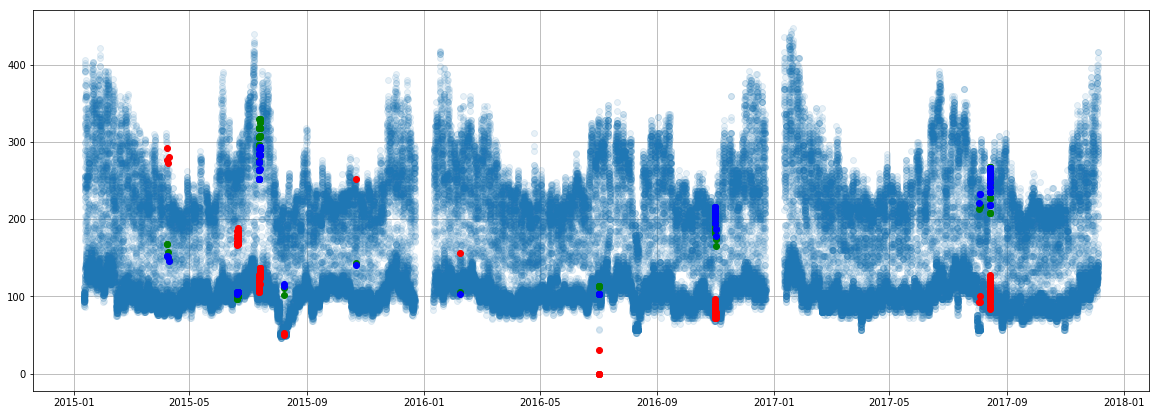

In [91]:
plt.figure(figsize=(20,7))
plt.plot(train.Timestamp,train[target], 'o',alpha = 0.1)
#plt.plot(train.Timestamp,train.Values_pred_1, 'o')
#plt.plot(train.Timestamp,train.Values_pred_2, 'o')

plt.plot(train[train['is_abnormal'] == True].Timestamp,train[train['is_abnormal'] == True][target], 'ro')
plt.plot(train[train['is_abnormal'] == True].Timestamp,train[train['is_abnormal'] == True].Values_pred_1, 'go')
plt.plot(train[train['is_abnormal'] == True].Timestamp,train[train['is_abnormal'] == True].Values_pred_2, 'bo')
#plt.ylim(-10000,160000)
plt.grid(True)

In [92]:
train.is_abnormal.fillna(False,inplace = True)

In [93]:
with open(interim_path+'train_nn_knn_38.pkl', 'wb') as f:
    pickle.dump(train,f)

In [94]:
### You can check if you have the same number of labeled anomalies. For best submission I had 144 of anomalies here. 

train.is_abnormal.sum()

139